<a href="https://colab.research.google.com/github/EternalSorrrow/bak/blob/master/hello_world_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
S, D, C = 100, 2, 3 #Samples, dimension, classes

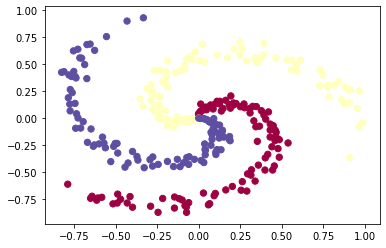

In [0]:
import matplotlib.pyplot as plt
import numpy as np

X = np.zeros((S*C, D)) #Input data
Y = np.zeros(S * C, dtype=np.uint8) #Labels

#Spiral data generation from cs231n
for j in range(C):
  ix = range(S*j,S*(j+1))
  r = np.linspace(0.0,1,S) # Radius
  t = np.linspace(j*4,(j+1)*4,S) + np.random.randn(S)*0.2 # Theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  Y[ix] = j
#Data visualization:
plt.scatter(X[:, 0], X[:, 1], c=Y, s=40, cmap=plt.cm.Spectral)
plt.show()

Multi-class linear classifier

In [0]:
W = 0.01 * np.random.randn(D, C) #Example model initialization
b = 0.01 * np.random.randn(1, C)

def raw_score(matrix, biases, data): #Raw scores
  return np.dot(data, matrix) + biases

def softmax(scores):
  exp_scores = np.exp(scores)
  return exp_scores/np.sum(exp_scores, axis=1, keepdims=True)

softmax(raw_score(W, b, X))[:5, :] #Sanity check, values in rows should be in [0, 1] interval and sum to one

array([[0.33105015, 0.32938227, 0.33956759],
       [0.33105701, 0.32937056, 0.33957243],
       [0.33109082, 0.3293403 , 0.33956888],
       [0.3310894 , 0.32933395, 0.33957665],
       [0.33108392, 0.32933091, 0.33958517]])

In [0]:
def compute_data_loss(probs, labels): #Li = - log(softmax(scores_of_i)[gt])
  log_probs = -np.log(probs)
  loss = sum([point[y] for point, y in zip(log_probs, labels)])
  return loss / probs.shape[0]

compute_data_loss(softmax(raw_score(W, b, X)), Y) #Sanity check, should be about -ln(0,33) ~ 1.1

1.0990816368274265

In [0]:
def compute_reg_loss(matrix, lambda_):
  return lambda_ * np.sum(matrix * matrix)

compute_reg_loss(W, 0.01) #Sanity check, values should be sane

2.5861537289715847e-06

In [0]:
#fj = j-th class raw scores (j-th component of XW+b vector)
#L = Loss on a single data point, -log(e^(fgt)/sum j(e^fj)) = - fgt + log (sum j (e^fj))
#dL/dfj = d(-fgt)/dfj + d(log(sum k (e^fk)))/dfj = -1(ground truth = f) + e^(fj)/sum k (e^k)
#dL/df gradient is a dL/dfj for every class (j), which is a row vector [1 x j], equal to the softmax values of the x'th data point with -1 added to the ground truth value
#Backprop into W
#dfj/dwik = d(sum l (wlj * xl) + bj)/dwik = xi(j=k)
#dL/dW matrix should have the size of W, with element on i, j index equal to dL/dfj * xi
#This corresponds to x.T * softmax(x) multiplication, where softmax(x) is a vector of sotmaxed scores of each class for x
#Total dW is an averaged sum of dW's for an every data point
#That leads to the matrix form of an equation: dW = X.T * probs(X), where X is a (num, dim) matrix
#of data points and probs is a (num, classes_num) matrix of softmax scores for every data point
#Backprop into b
#dfj/dbk = d(dot(x,w) + bj)/dbk = 1(k=j)
#dL/db vector should have the size of b, with element on i'th index equal to dL/dfi * dfi/dbi = 1 * dL/dfi = softmax(x)[i]
#delta b is a softmax scores for the corresponding data point x, for all data set it's average

def compute_weight_update(matrix, biases, data, probs, labels, lambda_, leraning_rate):
  dLdf = probs
  dLdf[range(dLdf.shape[0]), labels] -= 1
  
  dw = np.dot(X.T, dLdf) / data.shape[0]
  db = np.sum(dLdf, axis = 0, keepdims=True) / data.shape[0]

  dw_reg = 2*lambda_*matrix

  return dw + dw_reg, db

dw, db = compute_weight_update(W, b, X, softmax(raw_score(W, b, X)), Y, 0.01, 0.01)

In [0]:
epochs = 200
lr = 1.0
lambda_ = 0.001

W = 0.01 * np.random.randn(D, C)
b = 0.01 * np.random.randn(1, C)

def update_ratio(matrix, biases, dw, db): #Value, based on ratios between weights and their updates, useful to track learning dynamics
  return (np.sum(abs(dw)/abs(matrix)) + np.sum(abs(db)/abs(biases)))/(matrix.size + biases.size)

for i in range(epochs):
  probs = softmax(raw_score(W, b, X))
  data_loss = round(compute_data_loss(probs, Y), 4)
  reg_loss = round(compute_reg_loss(W, lambda_), 4)
  loss = data_loss + reg_loss

  dw, db = compute_weight_update(W, b, X, probs, Y, lambda_, lr)

  ur = round(update_ratio(W, b, dw, db), 4)

  W -= lr * dw
  b -= lr * db

  if i % 10 == 0:
    print('Epoch ' + str(i) + ', data loss ' + str(data_loss) + ', reg loss ' + str(reg_loss) + ', total loss ' + str(loss) + '\nUpdate ratio ' + str(ur))

Epoch 0, data loss 1.0955, reg loss 0.0, total loss 1.0955
Update ratio 7.6391
Epoch 10, data loss 0.9047, reg loss 0.0019, total loss 0.9066
Update ratio 0.0659
Epoch 20, data loss 0.8323, reg loss 0.005, total loss 0.8373
Update ratio 0.0384
Epoch 30, data loss 0.7981, reg loss 0.0078, total loss 0.8059000000000001
Update ratio 0.0527
Epoch 40, data loss 0.7795, reg loss 0.0102, total loss 0.7897
Update ratio 0.0209
Epoch 50, data loss 0.7683, reg loss 0.0122, total loss 0.7805
Update ratio 0.0144
Epoch 60, data loss 0.7611, reg loss 0.0139, total loss 0.775
Update ratio 0.0115
Epoch 70, data loss 0.7562, reg loss 0.0153, total loss 0.7715
Update ratio 0.0101
Epoch 80, data loss 0.7528, reg loss 0.0164, total loss 0.7692
Update ratio 0.01
Epoch 90, data loss 0.7504, reg loss 0.0174, total loss 0.7677999999999999
Update ratio 0.0122
Epoch 100, data loss 0.7486, reg loss 0.0183, total loss 0.7669
Update ratio 0.0303
Epoch 110, data loss 0.7472, reg loss 0.0189, total loss 0.7661
Update

In [0]:
scores = np.dot(X, W) + b
predicted_class = np.argmax(scores, axis=1)
print('Training accuracy:', round(np.mean(predicted_class == Y), 2))

Training accuracy: 0.54


Neural Network with a one hidden layer

In [0]:
h = 100 #Hidden layer size

W1 = 0.01 * np.random.randn(D, h) #Hidden layer matrix
b1 = 0.01 * np.random.randn(1, h)

W2 = 0.01 * np.random.randn(h, C)
b2 = 0.01 * np.random.randn(1, C)

#Example forward pass

hidden_output = np.maximum(0, np.dot(X, W1) + b1)
scores = np.dot(hidden_output, W2) + b2

print(scores[:5])
compute_data_loss(softmax(scores[:5]), Y) #Sanity check, should be about -ln(0,33) ~ 1.1

[[ 0.01513466  0.00390385 -0.00118715]
 [ 0.01513     0.00390756 -0.00119045]
 [ 0.0151235   0.00391359 -0.00120237]
 [ 0.01512027  0.0039179  -0.00120328]
 [ 0.01511777  0.00392228 -0.00120146]]


1.089457416911836

In [0]:
def compute_nn_reg_loss(matrices, lambda_):
  return lambda_ * np.sum([np.sum(matrix * matrix) for matrix in matrices])

compute_nn_reg_loss([W1, W2], 0.01) #Sanity check, values should be sane

0.00050305829227623

In [0]:
#Output layer weight update is identical
#After that, it's time to backprop into hidden layer
#Backprop into W1
#dL/dwji = sum k=children(j) (dL/dfk * dfk/dOj * dOj/dwji)
#dfk/dOj = d(O * wk + bk)/dOj = wkj
#dOj/dwji = (Oj > 0)(xi)
#Backprop into b1
#dL/dbj = sum k=children(j) (dL/dfk * dfk/dOj * dOj/dbj)
#dOj/dbj = (Oj > 0)(1)

def compute_nn_weight_update(matrix1, biases1, matrix2, biases2, data, hidden_layer, probs, labels, lambda_, leraning_rate):
  dLdf = probs
  dLdf[range(dLdf.shape[0]), labels] -= 1
  
  dw2 = np.dot(hidden_layer.T, dLdf) / data.shape[0]
  db2 = np.sum(dLdf, axis = 0, keepdims=True) / data.shape[0]

  dw2_reg = 2*lambda_*matrix2

  #TODO: rewrite this ugly cycle to matrix form
  '''
  dw1 = np.zeros((D, h), dtype=np.float64)
  db1 = np.zeros((1, h), dtype=np.float64)

  for s in range(data.shape[0]):
    for j in range(h):
      if hidden_layer[s][j] > 0:
        dLdOj = 0
        for k in range(C):
          dLdfk = dLdf[s][k]
          dfkdOj = matrix2[j][k]
          dLdOj += dLdfk * dfkdOj
        for i in range(D):
          dw1[i][j] += data[s][i] * dLdOj
        db1[0][j] += 1 * dLdOj
  '''
  #The graph visualization of the dradient calculating yielded the matrix form of the equation
  #grad by hidden layer output = grad L by fj * W2.T 
  #d relu (grad by hidden layer output[i,j]) = 1(hidden layer output[i,j] > 0)
  #grad by W1 = X.T * d relu (grad by hidden layer output)
  #grad by b1 = avg (d relu (grad by hidden layer output))

  dhidden = np.dot(dLdf, matrix2.T)
  dhidden[hidden_layer <= 0] = 0

  dw1 = np.dot(data.T, dhidden) / data.shape[0]
  db1 = np.sum(dhidden, axis = 0, keepdims=True) / data.shape[0]
  
  dw1_reg = 2 * lambda_ * matrix1

  return dw1 + dw1_reg, db1, dw2 + dw2_reg, db2

In [0]:
epochs = 2000
step = 100
lr = 1.0
lambda_ = 0.001

h = 100 #Hidden layer size

W1 = 0.01 * np.random.randn(D, h) #Hidden layer matrix
b1 = 0.01 * np.random.randn(1, h)

W2 = 0.01 * np.random.randn(h, C)
b2 = 0.01 * np.random.randn(1, C)

def update_ratio_nn(matrix1, biases1, matrix2, biases2, dw1, db1, dw2, db2): #Value, based on ratios between weights and their updates, useful to track learning dynamics
  return (np.sum(abs(dw1)/abs(matrix1)) + np.sum(abs(db1)/abs(biases1)) + np.sum(abs(dw2)/abs(matrix2)) + np.sum(abs(db2)/abs(matrix2)))/(matrix1.size + biases1.size + matrix2.size + biases2.size)


for i in range(epochs):
  hidden_layer = np.maximum(0, np.dot(X, W1) + b1)
  probs = softmax(np.dot(hidden_layer, W2) + b2)

  data_loss = round(compute_data_loss(probs, Y), 4)
  reg_loss = round(compute_nn_reg_loss([W1, W2], lambda_), 4)
  loss = data_loss + reg_loss

  dw1, db1, dw2, db2 = compute_nn_weight_update(W1, b1, W2, b2, X, hidden_layer, probs, Y, lambda_, lr)

  ur = round(update_ratio_nn(W1, b1, W2, b2, dw1, db1, dw2, db2), 4)

  W1 -= lr * dw1
  b1 -= lr * db1
  W2 -= lr * dw2
  b2 -= lr * db2

  if i % step == 0 or i == epochs - 1:
    print('Epoch ' + str(i) + ', data loss ' + str(data_loss) + ', reg loss ' + str(reg_loss) + ', total loss ' + str(loss) + '\nUpdate ratio ' + str(ur))

Epoch 0, data loss 1.0987, reg loss 0.0, total loss 1.0987
Update ratio 0.4992
Epoch 100, data loss 0.6874, reg loss 0.0195, total loss 0.7069
Update ratio 0.0322
Epoch 200, data loss 0.6997, reg loss 0.0273, total loss 0.727
Update ratio 3.74
Epoch 300, data loss 0.6619, reg loss 0.0376, total loss 0.6995
Update ratio 5.4355
Epoch 400, data loss 0.5488, reg loss 0.0612, total loss 0.61
Update ratio 5.7318
Epoch 500, data loss 0.477, reg loss 0.0904, total loss 0.5674
Update ratio 13.4703
Epoch 600, data loss 0.4492, reg loss 0.1094, total loss 0.5586
Update ratio 10.5094
Epoch 700, data loss 0.4137, reg loss 0.123, total loss 0.5367
Update ratio 11.8561
Epoch 800, data loss 0.3539, reg loss 0.137, total loss 0.4909
Update ratio 13.8591
Epoch 900, data loss 0.283, reg loss 0.1503, total loss 0.43329999999999996
Update ratio 9.8161
Epoch 1000, data loss 0.2313, reg loss 0.1613, total loss 0.3926
Update ratio 6.3016
Epoch 1100, data loss 0.2155, reg loss 0.1675, total loss 0.383
Update r

In [0]:
hidden_output = np.maximum(0, np.dot(X, W1) + b1)
probs = np.dot(hidden_output, W2) + b2
predicted_class = np.argmax(probs, axis=1)
print('Training accuracy:', round(np.mean(predicted_class == Y), 2))

Training accuracy: 0.89


MNIST Convolutional Network

In [132]:
#@title
import keras
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np

data = mnist.load_data()

(x_train, y_train), (x_test, y_test) = data

x_train, x_test = x_train / 255, x_test / 255 #Normalize data

x_train = x_train - np.mean(x_train) #Mean subtraction to make training more robust
x_test = x_test - np.mean(x_test)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [0]:
#[INPUT 28 x 28] -> [CONV2D 32F 3x3] -> [RELU] -> [AVGPOOL] -> [FLATTEN] -> [DROPOUT 0.5] -> [DENSE 128] -> [RELU] ->[DENSE 10] -> [SOFTMAX]
#            28 x 28 x 1        26 x 26 x 8            13 x 13 x 8    1 x 1352                         1 x 128                 1 x 10

input_size = 28 #Input image side

c1_filters = 32 #Filters in conv layer
c1_fdim = 3 #Filter size

c1_dim = (input_size - (c1_fdim - 1)) #Conv layer output map size

pool_dim = c1_dim // 2 #Pooling layer output map size

dense1_size = c1_filters * pool_dim * pool_dim #First dense layer input size
dense2_size = 128
output_size = 10

In [0]:
from skimage.measure import block_reduce
from scipy import signal

def softmax(scores):
  exp_scores = np.exp(scores)
  return exp_scores/np.sum(exp_scores, axis=1, keepdims=True)

def forward_pass(batch, dropout):
  if not (0 <= dropout < 1.0):
    raise ValueError('Dropout rate must be between 0 and 1.0!')
  
  dropout = 1 - dropout #Converting dropout rate to the alive neuron chance to simplify formula
  batch_size = batch.shape[0]

  out_conv = np.zeros(shape=(batch_size, c1_dim, c1_dim, c1_filters), dtype = np.float64) #Convolution map stack initialization

  for sample_index in range(batch_size): #For every sample in batch...
    image = batch[sample_index, :, :]
    for f in range(c1_filters): #...for every filter...
      kernel = C1[:,:,f]
      out_conv[sample_index, :, :, f] = signal.correlate(image, kernel, mode='valid') + bc[f]#...convolve filter with the image

  out_conv_relu = np.maximum(0, out_conv) #ReLU
  
  pooled = block_reduce(out_conv_relu, block_size=(1, 2, 2, 1), func=np.mean) #Avg pooling

  flat = np.reshape(pooled, (batch_size, dense1_size)) #Flattening

  drop_mask = (np.random.rand(*flat.shape) < dropout)/dropout #Dropout mask
  flat *= drop_mask #Drop

  hidden1 = np.maximum(0, np.dot(flat, W1) + b1) #Dense 1 layer
  hidden2 = np.dot(hidden1, W2) + b2 #Dense 2 layer

  classes = softmax(hidden2)

  return out_conv_relu, pooled, drop_mask, hidden1, hidden2, classes

#Forward pass example
#batch = x_train[:256]
#batch_labels = y_train[:256]
#_, _, _, _, _, _, classes = forward_pass(batch)
#print(classes.shape)
#print(classes[0])

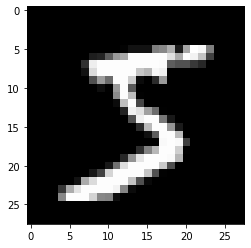

In [141]:
plt.figure()
plt.imshow(x_train[0], cmap = plt.cm.gray)

In [0]:
#[INPUT 28 x 28] -> [CONV2D 32F 3x3] -> [RELU] -> [AVGPOOL] -> [FLATTEN] -> [DROPOUT 0.5] -> [DENSE 128] -> [RELU] ->[DENSE 10] -> [SOFTMAX]
#            28 x 28 x 1        26 x 26 x 8            13 x 13 x 8    1 x 1352                         1 x 128                 1 x 10      

def compute_cnn_weight_update(batch, labels, out_conv, pooled, drop_mask, hidden1, hidden2, classes):
  N = batch.shape[0]
  
  dS = classes.copy()
  dS[range(N), labels] -= 1 #Backprop into softmax
  
  #Backprop into output layer
  dw2 = np.dot(hidden1.T, dS) / N
  db2 = np.sum(dS, axis=0, keepdims=True).reshape((output_size)) / N

  dhidden1 = np.dot(dS, W2.T) / N
  dhidden1[hidden1 <= 0] = 0 #ReLU gradient

  #Flattening the first dense layer input before backprop computing

  flat = np.reshape(pooled, (-1, dense1_size))

  dw1 = np.dot(flat.T, dhidden1) / N
  db1 = np.sum(dhidden1, axis=0, keepdims=True).reshape((dense2_size)) / N

  dflat = np.dot(dhidden1, W1.T) / N
  
  #Backprop into dropout
  dflat *= drop_mask

  #Backprop into pooling layer
  dpooled = np.reshape(dflat, (N, pool_dim, pool_dim, c1_filters))
  dout_conv_relu = dpooled.repeat(2, axis=1).repeat(2, axis=2) / 4.0

  #Backprop into convolutional layer ReLU
  dout_conv = dout_conv_relu
  dout_conv[out_conv <=0] = 0

  #Backprop into conv layer filters
  dc1 = np.zeros_like(C1)
  dbc = np.zeros_like(bc)

  for sample_index in range(N):
    for f in range(c1_filters):
      image = batch[sample_index]
      kernel = dout_conv[sample_index, :, :, f]
      conv = signal.correlate(image, kernel, mode='valid')
      dc1[:, :, f] += conv

  dc1 /= N
  dbc = np.sum(dout_conv, axis=(0, 1, 2)) / N

  return dc1, dbc, dw1, db1, dw2, db2

In [0]:
def compute_data_loss(classes, labels):
  N = classes.shape[0]
  log_probs = -np.log(classes)
  loss = np.sum(log_probs[range(N), labels])
  return loss / classes.shape[0]

def compute_accuracy(probs, Y):
  predicted_class = np.argmax(probs, axis=1)
  acc = round(np.mean(predicted_class == Y), 2)
  return acc

#compute_data_loss(classes, y_train)

In [0]:
C1 = np.sqrt(2.0/input_size * input_size) * np.random.randn(c1_fdim, c1_fdim, c1_filters) #Conv2d init, He method

#Initializing biases as small positive values to ensure intensive neuron firing and gradient recieving at the training start
bc = 0.01 * np.random.rand(c1_filters)

W1 = np.sqrt(2.0/dense1_size) * np.random.randn(dense1_size, dense2_size) #First dense init
b1 = 0.01 * np.random.rand(dense2_size)

W2 = np.sqrt(2.0/dense2_size) * np.random.randn(dense2_size, output_size) #Second dense init
b2 = 0.01 * np.random.rand(output_size)

epoch = 1

Epoch 2, 0.572, train loss 0.7046, train acc 0.76
Val loss 0.6093, val acc 0.83
Updates:
C1: 8e-10
bc: 5.471e-07
w1: 3.53316e-05
b1: 0.0001052725
w2: 0.0081046336
b2: 0.0117061999
Activations:
Conv	 Mean: 0.38749 	Nonzeros: 0.44153
D1-ReLU	 Mean: 0.70794 	Nonzeros: 0.5042
D2-Sfm	 Mean: 0.1 	Nonzeros: 1.0


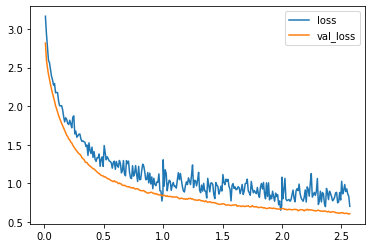

In [0]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

epochs = 10
batch_size = 512
lr = 0.1
dropout = 0.5 #Dropout rate, 0.0 means no dropout

valcheck = True #Validation check on each update flag

def predict(data):
  fp = forward_pass(data, 0.0)
  return np.argmax(fp[-1])

def batch_gen(data, labels, batch_size): #Batch generator
  i = 0
  k = 0
  while True:
    k = i + batch_size if i + batch_size <= data.shape[0] else data.shape[0]
    yield data[i:k], labels[i:k], k / data.shape[0]
    i = k
    if i == data.shape[0]:
      break 

def cyclic_batchgen(data, labels, batch_size): #Infinate cyclic batch generator for validation checks during training
  i = 0
  k = 0
  while True:
    batch = None
    batch_labels = None
    if i + batch_size <= data.shape[0]:
      k = i + batch_size
      batch = data[i:k]
      batch_labels = labels[i:k]
    else:
      delta = i + batch_size - data.shape[0]
      batch = data[i:]
      batch_labels = labels[i:]
      batch = np.concat(batch, data[:delta], axis=0)
      batch_labels = np.concat(batch_labels, labels[:delta], axis=0)

    yield batch, batch_labels

def compare_updates(weights, updates, lr): #Copare norms of update and weight matrices to follow the dynamics 
  return [ np.linalg.norm(update.ravel() * lr) / np.linalg.norm(weight.ravel()) for weight, update in zip(weights, updates)]

def activations(vectors): #Compute activations mean and non-zero count values to follow the dynamics and dead neurons fractions
  values = [(np.mean(vector), np.count_nonzero(vector)/ np.sum(np.ones_like(vector))) for vector in vectors]
  return values

#Plot data
landmarks = []
losses = []
val_losses = []

valgen = cyclic_batchgen(x_test, y_test, batch_size)

plt.figure()
for i in range(epochs):
  for train_batch, batch_labels, percent in batch_gen(x_train, y_train, batch_size):
    fp = forward_pass(train_batch, dropout)
    loss = round(compute_data_loss(fp[-1], batch_labels), 4)
    acc = round(compute_accuracy(fp[-1], batch_labels), 3)

    if valcheck:
      val_batch, val_labels = valgen.__next__() #Validation check
      fp_val = forward_pass(val_batch, 0.0)
      val_loss = round(compute_data_loss(fp_val[-1], val_labels), 4)
      val_acc = round(compute_accuracy(fp_val[-1], val_labels), 3)

    landmarks.append(i + epochs + percent) #Plot data updating
    losses.append(loss)
    if valcheck:
      val_losses.append(val_loss)

    dc1, dbc, dw1, db1, dw2, db2 = compute_cnn_weight_update(train_batch, batch_labels, *fp) #Weight updates

    actual_lr = lr * train_batch.shape[0] / batch_size #Decrease update rate for small residual batch at the end
    
    C1 -= actual_lr * dc1
    bc -= actual_lr * dbc

    W1 -= actual_lr * dw1
    b1 -= actual_lr * db1

    W2 -= actual_lr * dw2
    b2 -= actual_lr * db2
    
    param_names = ['C1', 'bc', 'w1', 'b1', 'w2', 'b2'] #Auxilary visualizing data
    layer_names = ['Conv', 'D1-ReLU', 'D2-Sfm']
    
    #Visualizing
    clear_output(wait=True)
    print('Epoch ' + str(i) + ', ' + str(round(percent, 3)) + ', train loss ' + str(loss) + ', train acc ' + str(acc))
    
    if valcheck:
      print('Val loss ' + str(val_loss) + ', val acc ' + str(val_acc))
    print('Updates:')
    for update, name in zip(compare_updates([C1, bc, W1, b1, W2, b2], [dc1, dbc, dw1, db1, dw2, db2], lr), param_names):
      print(name + ':', round(update, 10))

    print('Activations:')
    for activation, name in zip(activations([fp[0], fp[3], fp[5]]), layer_names):
      print(name + '\t', 'Mean:', round(activation[0], 5), '\tNonzeros:', round(activation[1], 5))

    plt.plot(landmarks, losses, label="loss")
    if valcheck:
      plt.plot(landmarks, val_losses, label="val_loss")
    plt.legend()
    plt.show()

  #Complete validation check on epoch end
  val_fp = forward_pass(x_test, 0.0)
  loss = round(compute_data_loss(val_fp[-1], y_test), 4)
  acc = compute_accuracy(val_fp[-1], y_test)
  print('Total val loss:', str(loss) + ', total val accuracy:', acc)
  print()
  epoch += 1

In [0]:
save = False
if save:
  np.save('toy_mnist_conv.npy', C1)
  np.save('toy_mnist_conv_b.npy', bc)
  np.save('toy_mnist_W1.npy', W1)
  np.save('toy_mnist_b1.npy', b1)
  np.save('toy_mnist_W2.npy', W2)
  np.save('toy_mnist_b2.npy', b2)